In [6]:
import configparser
import os.path
import re
from sys import stdout,stderr
import bitarray
import math, pprint, argparse, time

import joblib
from pylab import *

from petsysbuild.petsys import tofpet2b, tofpet2c, fe_power, daqd, config

In [7]:
# parser = argparse.ArgumentParser(description='Acquire data for threshold calibration')
# parser.add_argument("--config", type=str, required=True, help="Configuration file")
# parser.add_argument("-o", type=str, dest="outFilePrefix", required=True, help="Data file prefix")
# parser.add_argument("--nreads-noise", dest="noise_reads", type=int, required=False, default=4)
# parser.add_argument("--nreads-dark", dest="dark_reads", type=int, required=False, default=4)
# parser.add_argument("--ext-bias", dest="ext_bias", action="store_true", default=False, help="Prompt user to set bias")
# args = parser.parse_args()

class args:
	cdir = "/mnt/sda2/tofpet_data/two_preamp/"
	config = f"{cdir}/config.ini"
	output = f"{cdir}/disc_staircase_"
	dark_reads = 2 # Each counter period is 0.08s, 5 reads is 0.4s

disc_lsb_t1 = 55
disc_lsb_t2 = 55
disc_lsb_e = 48  # Default is 40

## Setup DAQ driver

In [15]:
# Some constant numbers
# Counter period is set to 0b111 = 2^24 cycles
COUNT_MAX = 1.0 * (2**24)

TriggerList = [ 
	(0,  "vth_t1", [0,0,0,0]),
	(1,  "vth_t2", [0,0,1,3]),
	(2,  "vth_e",  [3,2,2,2])
]


#######################
# DAQ setup
# Open daqd driver
idaqd = daqd.Connection()
idaqd.initializeSystem()
CLK_FREQ = idaqd.getSystemFrequency()
T = COUNT_MAX * (1 / CLK_FREQ)
counter_sharing = 1
print("* System CLK frequency: ",CLK_FREQ)

# Get active Asics and Channels
activeAsics = idaqd.getActiveAsics()
activeChannels = [ (portID, slaveID, chipID, channelID) for channelID in range(64) for portID, slaveID, chipID in activeAsics ]
# Get Asic configurations
asicsConfig = idaqd.getAsicsConfig()

# Get configuration file
systemConfig = config.ConfigFromFile(args.config, loadMask=config.LOAD_ALL^config.LOAD_QDCMODE_MAP)
systemConfig.loadToHardware(idaqd, bias_enable=config.APPLY_BIAS_OFF)
asicsConfig = idaqd.getAsicsConfig()



# Setup counter, discriminator LSB
for (portID, slaveID, chipID), ac in list(asicsConfig.items()):
	if not ac: continue
	gc = ac.globalConfig
	
	if idaqd.getAsicSubtype(portID, slaveID, chipID) == "2B":
		COUNTER_SETTING = 0x4
	else:
		COUNTER_SETTING = 0b111

	# print(portID, slaveID, chipID, COUNTER_SETTING)
	gc.setValue("counter_en", 0b1)
	gc.setValue("counter_period", COUNTER_SETTING)
	gc.setValue("disc_lsb_t1", disc_lsb_t1)
	gc.setValue("disc_lsb_t2", disc_lsb_t2)
	gc.setValue("disc_lsb_e", disc_lsb_e)

	for cc in ac.channelConfig:
		cc.setValue("trigger_mode_1", 0)
		cc.setValue("counter_mode", 0x2) # Count valid events
		cc.setValue("trigger_b_latched", 0)

INFO: active units on ports:  0
INFO: Evaluation kit: FEB/D with GBE connection @ ( 0,  0)
INFO: Setting FEM  power  ON @ (portID, slaveID) = (0,0)
INFO: FEB/D ( 0,  0) has  2 active ASICs: 4, 5
* System CLK frequency:  200000000.0
INFO: Setting BIAS power OFF @ (portID, slaveID) = (0,0)


## Take measurements

In [19]:
# ----------------------------------------------------
# Measure  trigger rate w.r.t a trigger threshold
# ----------------------------------------------------
print(f"Scanning trigger rate w.r.t. different discriminators")

data_save = {}
for ind, trigger_type, trigger_mode_setting in TriggerList:
	# if ind!=0:
	# 	continue

	stdout.write(f"  {trigger_type}"); stdout.flush()

	outdata = {}
	for portID, slaveID, chipID in activeAsics:
		outdata[(portID, slaveID, chipID)] = {}
		for channelID in range(len(asicsConfig[(portID, slaveID, chipID)].channelConfig)):
			outdata[(portID, slaveID, chipID)][channelID]={}
			for thresholdValue in range(0,62):
				outdata[(portID, slaveID, chipID)][channelID][thresholdValue]=[]

	for thresholdValue in range(0,62):
		for ac in list(asicsConfig.values()):
			for cc in ac.channelConfig:
				cc.setValue(trigger_type, 63 - thresholdValue) # Set threshold
				cc.setValue("trigger_mode_2_t", trigger_mode_setting[0])    # Set trigger to be single threshold on t1
				cc.setValue("trigger_mode_2_q", trigger_mode_setting[1])
				cc.setValue("trigger_mode_2_e", trigger_mode_setting[2])
				cc.setValue("trigger_mode_2_b", trigger_mode_setting[3])
				if ind==1:
					cc.setValue("vth_t1", 63 - 5) # For the scan of vth_t2, there is no t2 only trigger, need to set vth_t1 to a low value


		idaqd.setAsicsConfig(asicsConfig)
		time.sleep(1*T)
		next_read_start_time = time.time() + counter_sharing*T + 1E-3
		for n in range(args.dark_reads):
			s = next_read_start_time - time.time()
			if s > 0: time.sleep(s)
			next_read_start_time = time.time() + counter_sharing*T + 1E-3
			for portID, slaveID, chipID in activeAsics:
				vv = idaqd.read_mem_ctrl(portID, slaveID, 5, 24, 64*chipID, 64)
				for channelID, v in enumerate(vv):
					# Write out the number of triggers per second
					# -- v from vv is the counter value, divided by the max counter period T 
					v = v/T
					outdata[(portID, slaveID, chipID)][channelID][thresholdValue].append(v)

					# if chipID==4 and channelID==9:
					# 	print(v)

		stdout.write(".")
		stdout.flush()
		
	stdout.write("\n")
	data_save[trigger_type] = outdata

Scanning trigger rate w.r.t. different discriminators
  vth_t1..............................................................
  vth_t2..............................................................
  vth_e..............................................................


## Plot and save

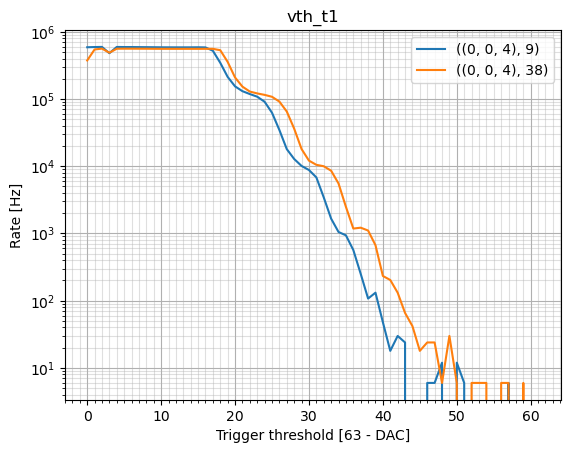

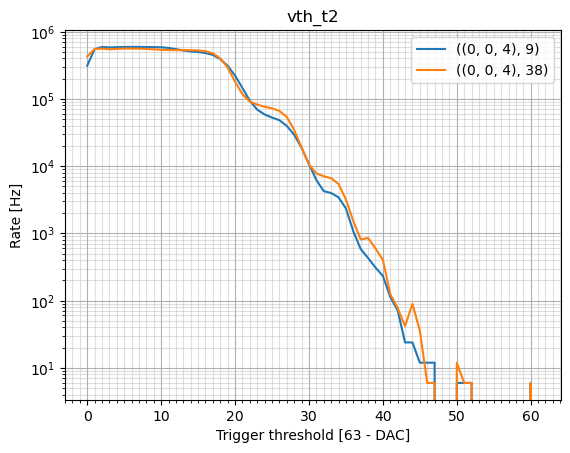

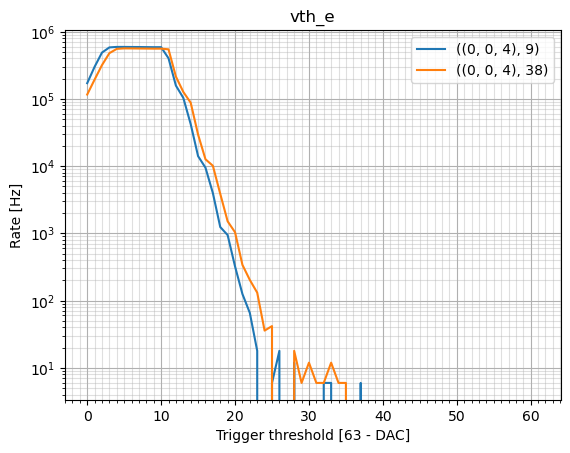

Zero of vth_t1 :
  Threshold at half maximum rate [19 20]
  channel (0, 0, 4, 9) need to be shifted by 0
  channel (0, 0, 4, 38) need to be shifted by -1
Zero of vth_t2 :
  Threshold at half maximum rate [20 20]
  channel (0, 0, 4, 9) need to be shifted by 0
  channel (0, 0, 4, 38) need to be shifted by 0
Zero of vth_e :
  Threshold at half maximum rate [0 0]
  channel (0, 0, 4, 9) need to be shifted by 0
  channel (0, 0, 4, 38) need to be shifted by 0


In [20]:
# portID, slaveID, chipID, channelID = 0,0,4,9
# outdata[(portID, slaveID, chipID)][channelID]

def plot_staircase(data, chips=None, channels = None):
    chips = data.keys() if chips is None else chips
    channels = data[chips[0]].keys() if channels is None else channels

    curve_save = {}
    for chip in chips:
        for ch in channels:
            thresholds = list(data[chip][ch].keys())
            trigger_rate = [np.mean(data[chip][ch][th]) for th in data[chip][ch].keys()]

            if np.max(trigger_rate)>0:
                plot(thresholds, trigger_rate, label = f"{chip,ch}")
                curve_save[chip+(ch,)] = [thresholds, trigger_rate]

    yscale("log")
    xlabel("Trigger threshold [63 - DAC]")
    ylabel("Rate [Hz]")
    gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    gca().xaxis.set_major_locator(plt.MultipleLocator(10))
    grid(which="major")
    grid(which="minor", alpha=0.4)
    legend()
    return curve_save


def process_staircase(curve_save_all, ref_channel = (0,0,4,9), ref_rate=0.5):
    """
    calculate the baseline offset of each channel relative to the ref_channel

    INPUT:
    ref_channel: tuple, (portID, slaveID, chipID, channelID)
    ref_rate   : fraction of the maximum rate to align the curves
    
    """
    for disc_type in curve_save_all:
        print("Zero of",disc_type,":")
        curves = curve_save_all[disc_type]

        max_rate_min = np.min([max(curves[i][1]) for i in curves.keys()])
        rate_to_align = max_rate_min* ref_rate
        threshold_value_when_passing_aligning_rate = np.array([curves[i][0][np.argmax(curves[i][1]<rate_to_align)] for i in curves.keys()])
        print("  Threshold at half maximum rate", threshold_value_when_passing_aligning_rate)
        threshold_of_ref_channel = None
        for i, ch in enumerate(curves.keys()):
            if ch==ref_channel:
                threshold_of_ref_channel = threshold_value_when_passing_aligning_rate[i]
        for i, ch in enumerate(curves.keys()):
            print("  channel", ch, "need to be shifted by", -(threshold_value_when_passing_aligning_rate[i]-threshold_of_ref_channel))




##################################################
# Save output and figures
##################################################
# Save Raw
joblib.dump(data_save, args.output+"rawdata.joblib")
# Save plots
curve_save_all = {}
for key in data_save:
    curve_save = plot_staircase(data_save[key], chips = [(0,0,4)], channels =[9,38])
    title(key)
    savefig(args.output+f"{key}.jpg")
    show()
    curve_save_all[key] = curve_save
# Save plot data
joblib.dump(data_save, args.output+"curves.joblib")


# Process the curves, find the offset on x axis'
# ********** Use these numbers to change the "zeros" in "disc_calibration.tsv" file
process_staircase(curve_save_all,  ref_channel = (0,0,4,9), ref_rate=0.5)